In [36]:
%load_ext autoreload
%autoreload 1
%aimport helpers, plotters, loaders

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
# This helps with joblib "No space left on device" errors
%env JOBLIB_TEMP_FOLDER=/tmp

env: JOBLIB_TEMP_FOLDER=/tmp


In [38]:
from pprint import pprint
from math import ceil, floor
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from helpers import balanced_accuracy_scorer, balanced_accuracy, load_best_search, load_best_learning, save_learning_curve, save_search_result, scikit_cv_result_to_df
from loaders import load_adult, load_mnist
from plotters import plot_means_w_stds, gen_and_plot_learning_curve, plot_learning_curve, gen_and_plot_validation_curve, plot_validation_curve

### Load Data

In [39]:
dataset = 'adult'
learner_type = 'BB'
loader_func = load_adult
df = loader_func(preprocess=True)

Dataset shape (30162, 105)
Value composition:
0    0.751078
1    0.248922
Name: target, dtype: float64


### Split data into training and testing

In [40]:
from sklearn.model_selection import train_test_split

X = df[[c for c in df.columns if c != 'target']]
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

### Scale Data

In [41]:
# Use min max scaling because input dataset is sparse, i.e. mostly zeros
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## AdaBoost Model Complexity

In [42]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

base_clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

base_clf.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator__class_weight': None,
 'base_estimator__criterion': 'gini',
 'base_estimator__max_depth': None,
 'base_estimator__max_features': None,
 'base_estimator__max_leaf_nodes': None,
 'base_estimator__min_impurity_decrease': 0.0,
 'base_estimator__min_impurity_split': None,
 'base_estimator__min_samples_leaf': 1,
 'base_estimator__min_samples_split': 2,
 'base_estimator__min_weight_fraction_leaf': 0.0,
 'base_estimator__presort': False,
 'base_estimator__random_state': None,
 'base_estimator__splitter': 'best',
 'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=None,
             splitter='best'),
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': None}

In [43]:
param_grid = {
    'n_estimators': [1, 10, 20, 50, 100, 150, 200, 250, 300, 400],
    'base_estimator__max_depth': range(2, 11),
    'learning_rate': [.5, .75, 1.0]
}

In [8]:
grid_search = GridSearchCV(
    estimator=base_clf,
    param_grid=param_grid,
    scoring=balanced_accuracy_scorer,
    return_train_score=True,
    cv=4,
    verbose=10,
    n_jobs=-1,
)

In [9]:
grid_search.fit(X_train_scaled, y_train)

Fitting 4 folds for each of 300 candidates, totalling 1200 fits
[CV] base_estimator__max_depth=1, learning_rate=0.5, n_estimators=1 ..
[CV] base_estimator__max_depth=1, learning_rate=0.5, n_estimators=1 ..
[CV] base_estimator__max_depth=1, learning_rate=0.5, n_estimators=1 ..
[CV]  base_estimator__max_depth=1, learning_rate=0.5, n_estimators=1, score=0.4999999999999999, total=   0.1s
[CV] base_estimator__max_depth=1, learning_rate=0.5, n_estimators=1 ..
[CV] base_estimator__max_depth=1, learning_rate=0.5, n_estimators=10 .
[CV]  base_estimator__max_depth=1, learning_rate=0.5, n_estimators=1, score=0.5, total=   0.1s
[CV] base_estimator__max_depth=1, learning_rate=0.5, n_estimators=10 .
[CV]  base_estimator__max_depth=1, learning_rate=0.5, n_estimators=1, score=0.5, total=   0.1s
[CV] base_estimator__max_depth=1, learning_rate=0.5, n_estimators=10 .
[CV]  base_estimator__max_depth=1, learning_rate=0.5, n_estimators=1, score=0.5, total=   0.1s


[Parallel(n_jobs=-1)]: Batch computation too fast (0.1749s.) Setting batch_size=2.


[CV] base_estimator__max_depth=1, learning_rate=0.5, n_estimators=10 .
[CV]  base_estimator__max_depth=1, learning_rate=0.5, n_estimators=10, score=0.7360554970144011, total=   0.7s
[CV] base_estimator__max_depth=1, learning_rate=0.5, n_estimators=20 .
[CV]  base_estimator__max_depth=1, learning_rate=0.5, n_estimators=10, score=0.7335333066087942, total=   0.6s
[CV] base_estimator__max_depth=1, learning_rate=0.5, n_estimators=20 .
[CV]  base_estimator__max_depth=1, learning_rate=0.5, n_estimators=10, score=0.7418877968689285, total=   0.7s
[CV]  base_estimator__max_depth=1, learning_rate=0.5, n_estimators=10, score=0.7304617124900359, total=   0.7s
[CV] base_estimator__max_depth=1, learning_rate=0.5, n_estimators=50 .


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.9s


[CV] base_estimator__max_depth=1, learning_rate=0.5, n_estimators=50 .
[CV]  base_estimator__max_depth=1, learning_rate=0.5, n_estimators=20, score=0.7444401258346912, total=   1.3s
[CV] base_estimator__max_depth=1, learning_rate=0.5, n_estimators=20 .
[CV]  base_estimator__max_depth=1, learning_rate=0.5, n_estimators=20, score=0.7506396994564475, total=   1.3s
[CV] base_estimator__max_depth=1, learning_rate=0.5, n_estimators=20 .
[CV]  base_estimator__max_depth=1, learning_rate=0.5, n_estimators=20, score=0.736665568503134, total=   1.3s
[CV] base_estimator__max_depth=1, learning_rate=0.5, n_estimators=100 
[CV]  base_estimator__max_depth=1, learning_rate=0.5, n_estimators=20, score=0.7406306684052976, total=   1.3s
[CV] base_estimator__max_depth=1, learning_rate=0.5, n_estimators=100 


[Parallel(n_jobs=-1)]: Batch computation too slow (3.4907s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.8s


[CV]  base_estimator__max_depth=1, learning_rate=0.5, n_estimators=50, score=0.763994694827841, total=   3.0s
[CV] base_estimator__max_depth=1, learning_rate=0.5, n_estimators=50 .
[CV]  base_estimator__max_depth=1, learning_rate=0.5, n_estimators=50, score=0.7667813594803767, total=   3.0s
[CV] base_estimator__max_depth=1, learning_rate=0.5, n_estimators=50 .
[CV]  base_estimator__max_depth=1, learning_rate=0.5, n_estimators=50, score=0.7639683713543659, total=   3.0s
[CV]  base_estimator__max_depth=1, learning_rate=0.5, n_estimators=50, score=0.760186426698736, total=   3.0s
[CV] base_estimator__max_depth=1, learning_rate=0.5, n_estimators=150 
[CV] base_estimator__max_depth=1, learning_rate=0.5, n_estimators=150 
[CV]  base_estimator__max_depth=1, learning_rate=0.5, n_estimators=100, score=0.7690719403609588, total=   5.7s
[CV] base_estimator__max_depth=1, learning_rate=0.5, n_estimators=100 
[CV]  base_estimator__max_depth=1, learning_rate=0.5, n_estimators=100, score=0.77781003153

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   26.8s


[CV]  base_estimator__max_depth=1, learning_rate=0.5, n_estimators=200, score=0.7864294633436085, total=  10.6s
[CV] base_estimator__max_depth=1, learning_rate=0.5, n_estimators=250 
[CV]  base_estimator__max_depth=1, learning_rate=0.5, n_estimators=200, score=0.7753902320273635, total=  10.6s
[CV] base_estimator__max_depth=1, learning_rate=0.5, n_estimators=250 
[CV]  base_estimator__max_depth=1, learning_rate=0.5, n_estimators=250, score=0.7794653945002022, total=  13.7s
[CV] base_estimator__max_depth=1, learning_rate=0.5, n_estimators=300 
[CV]  base_estimator__max_depth=1, learning_rate=0.5, n_estimators=250, score=0.7756741802554804, total=  13.6s
[CV] base_estimator__max_depth=1, learning_rate=0.5, n_estimators=300 
[CV]  base_estimator__max_depth=1, learning_rate=0.5, n_estimators=250, score=0.785416157902093, total=  13.7s
[CV] base_estimator__max_depth=1, learning_rate=0.5, n_estimators=300 
[CV]  base_estimator__max_depth=1, learning_rate=0.5, n_estimators=250, score=0.780210

[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   50.7s


[CV]  base_estimator__max_depth=1, learning_rate=0.5, n_estimators=300, score=0.7832727768276837, total=  16.4s
[CV] base_estimator__max_depth=1, learning_rate=0.5, n_estimators=400 
[CV]  base_estimator__max_depth=1, learning_rate=0.5, n_estimators=300, score=0.776939756130901, total=  16.4s
[CV] base_estimator__max_depth=1, learning_rate=0.5, n_estimators=400 
[CV]  base_estimator__max_depth=1, learning_rate=0.5, n_estimators=300, score=0.7869403397702611, total=  16.7s
[CV] base_estimator__max_depth=1, learning_rate=0.5, n_estimators=400 
[CV]  base_estimator__max_depth=1, learning_rate=0.5, n_estimators=300, score=0.7831288291733671, total=  16.7s
[CV] base_estimator__max_depth=1, learning_rate=0.5, n_estimators=400 
[CV]  base_estimator__max_depth=1, learning_rate=0.5, n_estimators=400, score=0.7839121230093608, total=  21.9s
[CV] base_estimator__max_depth=1, learning_rate=0.75, n_estimators=1 .
[CV]  base_estimator__max_depth=1, learning_rate=0.75, n_estimators=1, score=0.4999999

[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:  1.4min


[CV]  base_estimator__max_depth=1, learning_rate=0.75, n_estimators=10, score=0.739234569607352, total=   0.7s
[CV] base_estimator__max_depth=1, learning_rate=0.75, n_estimators=10 
[CV]  base_estimator__max_depth=1, learning_rate=0.75, n_estimators=10, score=0.7433090739025661, total=   0.6s
[CV] base_estimator__max_depth=1, learning_rate=0.75, n_estimators=10 
[CV]  base_estimator__max_depth=1, learning_rate=0.75, n_estimators=10, score=0.7496432888385116, total=   0.6s
[CV] base_estimator__max_depth=1, learning_rate=0.75, n_estimators=20 
[CV]  base_estimator__max_depth=1, learning_rate=0.75, n_estimators=10, score=0.7364301928928085, total=   0.7s
[CV] base_estimator__max_depth=1, learning_rate=0.75, n_estimators=20 
[CV]  base_estimator__max_depth=1, learning_rate=0.75, n_estimators=20, score=0.7511832031032569, total=   1.2s
[CV] base_estimator__max_depth=1, learning_rate=0.75, n_estimators=20 
[CV]  base_estimator__max_depth=1, learning_rate=0.75, n_estimators=20, score=0.749918

[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:  1.5min


[CV]  base_estimator__max_depth=1, learning_rate=0.75, n_estimators=50, score=0.7680631131226234, total=   2.6s
[CV] base_estimator__max_depth=1, learning_rate=0.75, n_estimators=50 
[CV]  base_estimator__max_depth=1, learning_rate=0.75, n_estimators=50, score=0.7636279790565623, total=   2.6s
[CV] base_estimator__max_depth=1, learning_rate=0.75, n_estimators=50 
[CV]  base_estimator__max_depth=1, learning_rate=0.5, n_estimators=400, score=0.7880818922816766, total=  21.1s
[CV] base_estimator__max_depth=1, learning_rate=0.75, n_estimators=100 
[CV]  base_estimator__max_depth=1, learning_rate=0.5, n_estimators=400, score=0.7861729692038084, total=  21.1s
[CV] base_estimator__max_depth=1, learning_rate=0.75, n_estimators=100 
[CV]  base_estimator__max_depth=1, learning_rate=0.75, n_estimators=50, score=0.7734960919201274, total=   2.5s
[CV] base_estimator__max_depth=1, learning_rate=0.75, n_estimators=100 
[CV]  base_estimator__max_depth=1, learning_rate=0.75, n_estimators=50, score=0.76

[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  1.8min


[CV]  base_estimator__max_depth=1, learning_rate=0.75, n_estimators=150, score=0.7788212251204523, total=   8.0s
[CV]  base_estimator__max_depth=1, learning_rate=0.75, n_estimators=150, score=0.7851702230270302, total=   8.1s
[CV] base_estimator__max_depth=1, learning_rate=0.75, n_estimators=200 
[CV] base_estimator__max_depth=1, learning_rate=0.75, n_estimators=200 
[CV]  base_estimator__max_depth=1, learning_rate=0.75, n_estimators=200, score=0.7808701902683488, total=  10.8s
[CV] base_estimator__max_depth=1, learning_rate=0.75, n_estimators=250 
[CV]  base_estimator__max_depth=1, learning_rate=0.75, n_estimators=200, score=0.7754261335274701, total=  10.8s
[CV] base_estimator__max_depth=1, learning_rate=0.75, n_estimators=250 
[CV]  base_estimator__max_depth=1, learning_rate=0.75, n_estimators=200, score=0.7813608242830835, total=  10.6s
[CV] base_estimator__max_depth=1, learning_rate=0.75, n_estimators=250 
[CV]  base_estimator__max_depth=1, learning_rate=0.75, n_estimators=200, sc

[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:  2.2min


[CV]  base_estimator__max_depth=1, learning_rate=0.75, n_estimators=300, score=0.7839165375882196, total=  16.4s
[CV] base_estimator__max_depth=1, learning_rate=0.75, n_estimators=400 
[CV]  base_estimator__max_depth=1, learning_rate=0.75, n_estimators=300, score=0.7784702735579117, total=  16.5s
[CV] base_estimator__max_depth=1, learning_rate=0.75, n_estimators=400 
[CV]  base_estimator__max_depth=1, learning_rate=0.75, n_estimators=300, score=0.7898667919955398, total=  16.2s
[CV] base_estimator__max_depth=1, learning_rate=0.75, n_estimators=400 
[CV]  base_estimator__max_depth=1, learning_rate=0.75, n_estimators=300, score=0.7864379107553983, total=  16.4s
[CV] base_estimator__max_depth=1, learning_rate=0.75, n_estimators=400 
[CV]  base_estimator__max_depth=1, learning_rate=0.75, n_estimators=400, score=0.7861974353216212, total=  21.5s
[CV] base_estimator__max_depth=1, learning_rate=1.0, n_estimators=1 ..
[CV]  base_estimator__max_depth=1, learning_rate=1.0, n_estimators=1, score=

[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:  2.9min


[CV]  base_estimator__max_depth=1, learning_rate=1.0, n_estimators=10, score=0.7496517362503015, total=   0.6s
[CV] base_estimator__max_depth=1, learning_rate=1.0, n_estimators=20 .
[CV]  base_estimator__max_depth=1, learning_rate=0.75, n_estimators=400, score=0.7865661578252983, total=  21.4s
[CV] base_estimator__max_depth=1, learning_rate=1.0, n_estimators=20 .
[CV]  base_estimator__max_depth=1, learning_rate=1.0, n_estimators=20, score=0.7626494958742881, total=   1.1s
[CV] base_estimator__max_depth=1, learning_rate=1.0, n_estimators=50 .
[CV]  base_estimator__max_depth=1, learning_rate=1.0, n_estimators=20, score=0.7588263934005748, total=   1.0s
[CV] base_estimator__max_depth=1, learning_rate=1.0, n_estimators=50 .
[CV]  base_estimator__max_depth=1, learning_rate=1.0, n_estimators=20, score=0.7582859510326577, total=   1.1s
[CV] base_estimator__max_depth=1, learning_rate=1.0, n_estimators=50 .
[CV]  base_estimator__max_depth=1, learning_rate=1.0, n_estimators=20, score=0.765778613

[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:  3.1min


[CV]  base_estimator__max_depth=1, learning_rate=1.0, n_estimators=100, score=0.7807217007865309, total=   5.4s
[CV] base_estimator__max_depth=1, learning_rate=1.0, n_estimators=150 
[CV]  base_estimator__max_depth=1, learning_rate=1.0, n_estimators=100, score=0.7877203814543986, total=   5.6s
[CV] base_estimator__max_depth=1, learning_rate=1.0, n_estimators=150 
[CV]  base_estimator__max_depth=1, learning_rate=1.0, n_estimators=150, score=0.7855602964293733, total=   8.0s
[CV] base_estimator__max_depth=1, learning_rate=1.0, n_estimators=200 
[CV]  base_estimator__max_depth=1, learning_rate=1.0, n_estimators=150, score=0.7745389633029074, total=   8.1s
[CV] base_estimator__max_depth=1, learning_rate=1.0, n_estimators=200 
[CV]  base_estimator__max_depth=1, learning_rate=1.0, n_estimators=150, score=0.7888555984069718, total=   8.1s
[CV] base_estimator__max_depth=1, learning_rate=1.0, n_estimators=200 
[CV]  base_estimator__max_depth=1, learning_rate=1.0, n_estimators=150, score=0.78555

[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:  3.9min


[CV]  base_estimator__max_depth=1, learning_rate=1.0, n_estimators=300, score=0.7834212248132739, total=  16.4s
[CV] base_estimator__max_depth=1, learning_rate=1.0, n_estimators=400 
[CV]  base_estimator__max_depth=1, learning_rate=1.0, n_estimators=300, score=0.7901317335471296, total=  16.3s
[CV] base_estimator__max_depth=1, learning_rate=1.0, n_estimators=400 
[CV]  base_estimator__max_depth=1, learning_rate=1.0, n_estimators=300, score=0.7891078688408768, total=  16.5s
[CV] base_estimator__max_depth=1, learning_rate=1.0, n_estimators=400 
[CV]  base_estimator__max_depth=1, learning_rate=1.0, n_estimators=400, score=0.7888610578482574, total=  20.3s
[CV] base_estimator__max_depth=2, learning_rate=0.5, n_estimators=1 ..
[CV]  base_estimator__max_depth=2, learning_rate=0.5, n_estimators=1, score=0.702968132498786, total=   0.1s
[CV] base_estimator__max_depth=2, learning_rate=0.5, n_estimators=1 ..
[CV]  base_estimator__max_depth=2, learning_rate=0.5, n_estimators=1, score=0.6951094861

[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:  4.3min


[CV]  base_estimator__max_depth=2, learning_rate=0.5, n_estimators=20, score=0.7532008575799278, total=   1.8s
[CV] base_estimator__max_depth=2, learning_rate=0.5, n_estimators=50 .
[CV]  base_estimator__max_depth=2, learning_rate=0.5, n_estimators=20, score=0.760945349853399, total=   1.8s
[CV] base_estimator__max_depth=2, learning_rate=0.5, n_estimators=50 .
[CV]  base_estimator__max_depth=2, learning_rate=0.5, n_estimators=20, score=0.7633440308284453, total=   2.0s
[CV] base_estimator__max_depth=2, learning_rate=0.5, n_estimators=50 .
[CV]  base_estimator__max_depth=2, learning_rate=0.5, n_estimators=20, score=0.7601589726104192, total=   2.0s
[CV] base_estimator__max_depth=2, learning_rate=0.5, n_estimators=50 .
[CV]  base_estimator__max_depth=2, learning_rate=0.5, n_estimators=50, score=0.7811135679202151, total=   5.0s
[CV] base_estimator__max_depth=2, learning_rate=0.5, n_estimators=100 
[CV]  base_estimator__max_depth=2, learning_rate=0.5, n_estimators=50, score=0.783530465206

[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed:  5.2min


[CV]  base_estimator__max_depth=2, learning_rate=0.5, n_estimators=200, score=0.7909138870842145, total=  21.1s
[CV] base_estimator__max_depth=2, learning_rate=0.5, n_estimators=250 
[CV]  base_estimator__max_depth=2, learning_rate=0.5, n_estimators=200, score=0.7912796216173876, total=  20.9s
[CV] base_estimator__max_depth=2, learning_rate=0.5, n_estimators=250 
[CV]  base_estimator__max_depth=2, learning_rate=0.5, n_estimators=200, score=0.7939284611733916, total=  21.2s
[CV] base_estimator__max_depth=2, learning_rate=0.5, n_estimators=250 
[CV]  base_estimator__max_depth=2, learning_rate=0.5, n_estimators=250, score=0.7858323688438218, total=  23.6s
[CV] base_estimator__max_depth=2, learning_rate=0.5, n_estimators=300 
[CV]  base_estimator__max_depth=2, learning_rate=0.5, n_estimators=250, score=0.7904072343634567, total=  23.6s
[CV] base_estimator__max_depth=2, learning_rate=0.5, n_estimators=300 
[CV]  base_estimator__max_depth=2, learning_rate=0.5, n_estimators=250, score=0.79369

[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:  6.9min


[CV]  base_estimator__max_depth=2, learning_rate=0.5, n_estimators=400, score=0.791052693418852, total=  39.8s
[CV] base_estimator__max_depth=2, learning_rate=0.75, n_estimators=10 
[CV]  base_estimator__max_depth=2, learning_rate=0.75, n_estimators=10, score=0.75511668883553, total=   0.9s
[CV] base_estimator__max_depth=2, learning_rate=0.75, n_estimators=10 
[CV]  base_estimator__max_depth=2, learning_rate=0.75, n_estimators=10, score=0.7510645658721492, total=   0.9s
[CV] base_estimator__max_depth=2, learning_rate=0.75, n_estimators=20 
[CV]  base_estimator__max_depth=2, learning_rate=0.75, n_estimators=10, score=0.7627196903025248, total=   0.9s
[CV] base_estimator__max_depth=2, learning_rate=0.75, n_estimators=20 
[CV]  base_estimator__max_depth=2, learning_rate=0.75, n_estimators=10, score=0.752294240247463, total=   0.9s
[CV] base_estimator__max_depth=2, learning_rate=0.75, n_estimators=20 
[CV]  base_estimator__max_depth=2, learning_rate=0.5, n_estimators=400, score=0.795978302

[Parallel(n_jobs=-1)]: Done 181 tasks      | elapsed:  7.4min


[CV]  base_estimator__max_depth=2, learning_rate=0.75, n_estimators=150, score=0.7971198549502602, total=  15.3s
[CV] base_estimator__max_depth=2, learning_rate=0.75, n_estimators=200 
[CV]  base_estimator__max_depth=2, learning_rate=0.75, n_estimators=150, score=0.7864843715202423, total=  15.5s
[CV] base_estimator__max_depth=2, learning_rate=0.75, n_estimators=200 
[CV]  base_estimator__max_depth=2, learning_rate=0.75, n_estimators=150, score=0.7903840039810349, total=  15.4s
[CV] base_estimator__max_depth=2, learning_rate=0.75, n_estimators=200 
[CV]  base_estimator__max_depth=2, learning_rate=0.75, n_estimators=200, score=0.7906618221462146, total=  19.9s
[CV] base_estimator__max_depth=2, learning_rate=0.75, n_estimators=250 
[CV]  base_estimator__max_depth=2, learning_rate=0.75, n_estimators=200, score=0.7857233365126319, total=  19.8s
[CV] base_estimator__max_depth=2, learning_rate=0.75, n_estimators=250 
[CV]  base_estimator__max_depth=2, learning_rate=0.75, n_estimators=200, sc

[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:  9.3min


[CV]  base_estimator__max_depth=2, learning_rate=1.0, n_estimators=1, score=0.6935536264738813, total=   0.2s
[CV] base_estimator__max_depth=2, learning_rate=1.0, n_estimators=10 .
[CV]  base_estimator__max_depth=2, learning_rate=0.75, n_estimators=400, score=0.7865054900497168, total=  35.2s
[CV] base_estimator__max_depth=2, learning_rate=1.0, n_estimators=10 .
[CV]  base_estimator__max_depth=2, learning_rate=1.0, n_estimators=10, score=0.7623641797232634, total=   0.9s
[CV] base_estimator__max_depth=2, learning_rate=1.0, n_estimators=10 .
[CV]  base_estimator__max_depth=2, learning_rate=1.0, n_estimators=10, score=0.7553890647486434, total=   1.0s
[CV] base_estimator__max_depth=2, learning_rate=1.0, n_estimators=20 .
[CV]  base_estimator__max_depth=2, learning_rate=1.0, n_estimators=10, score=0.7603167856215837, total=   0.9s
[CV] base_estimator__max_depth=2, learning_rate=1.0, n_estimators=20 .
[CV]  base_estimator__max_depth=2, learning_rate=1.0, n_estimators=10, score=0.7637372194

[Parallel(n_jobs=-1)]: Done 221 tasks      | elapsed:  9.8min


[CV]  base_estimator__max_depth=2, learning_rate=1.0, n_estimators=150, score=0.7896694297382686, total=  15.0s
[CV] base_estimator__max_depth=2, learning_rate=1.0, n_estimators=200 
[CV]  base_estimator__max_depth=2, learning_rate=1.0, n_estimators=150, score=0.8005487361904017, total=  14.7s
[CV] base_estimator__max_depth=2, learning_rate=1.0, n_estimators=200 
[CV]  base_estimator__max_depth=2, learning_rate=1.0, n_estimators=150, score=0.7907814163084196, total=  14.7s
[CV] base_estimator__max_depth=2, learning_rate=1.0, n_estimators=200 
[CV]  base_estimator__max_depth=2, learning_rate=1.0, n_estimators=200, score=0.7877504073888534, total=  18.2s
[CV] base_estimator__max_depth=2, learning_rate=1.0, n_estimators=250 
[CV]  base_estimator__max_depth=2, learning_rate=1.0, n_estimators=200, score=0.7805496807646289, total=  18.3s
[CV] base_estimator__max_depth=2, learning_rate=1.0, n_estimators=250 
[CV]  base_estimator__max_depth=2, learning_rate=1.0, n_estimators=200, score=0.79320

[Parallel(n_jobs=-1)]: Done 242 tasks      | elapsed: 11.7min


[CV]  base_estimator__max_depth=2, learning_rate=1.0, n_estimators=400, score=0.7821999978497497, total=  37.8s
[CV] base_estimator__max_depth=3, learning_rate=0.5, n_estimators=10 .
[CV]  base_estimator__max_depth=3, learning_rate=0.5, n_estimators=10, score=0.7624704175231909, total=   1.2s
[CV] base_estimator__max_depth=3, learning_rate=0.5, n_estimators=10 .
[CV]  base_estimator__max_depth=3, learning_rate=0.5, n_estimators=10, score=0.7635102912513996, total=   1.3s
[CV] base_estimator__max_depth=3, learning_rate=0.5, n_estimators=20 .
[CV]  base_estimator__max_depth=3, learning_rate=0.5, n_estimators=10, score=0.7651120357187289, total=   1.2s
[CV] base_estimator__max_depth=3, learning_rate=0.5, n_estimators=20 .
[CV]  base_estimator__max_depth=3, learning_rate=0.5, n_estimators=10, score=0.7511357929124679, total=   1.1s
[CV] base_estimator__max_depth=3, learning_rate=0.5, n_estimators=20 .
[CV]  base_estimator__max_depth=2, learning_rate=1.0, n_estimators=400, score=0.784840389

[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed: 12.9min


[CV]  base_estimator__max_depth=3, learning_rate=0.5, n_estimators=200, score=0.7856309909428387, total=  26.9s
[CV] base_estimator__max_depth=3, learning_rate=0.5, n_estimators=250 
[CV]  base_estimator__max_depth=3, learning_rate=0.5, n_estimators=200, score=0.7906827351797839, total=  26.8s
[CV] base_estimator__max_depth=3, learning_rate=0.5, n_estimators=250 
[CV]  base_estimator__max_depth=3, learning_rate=0.5, n_estimators=200, score=0.7768495224140554, total=  26.9s
[CV] base_estimator__max_depth=3, learning_rate=0.5, n_estimators=250 
[CV]  base_estimator__max_depth=3, learning_rate=0.5, n_estimators=250, score=0.7824430279404453, total=  35.3s
[CV] base_estimator__max_depth=3, learning_rate=0.5, n_estimators=300 
[CV]  base_estimator__max_depth=3, learning_rate=0.5, n_estimators=250, score=0.7824417090189176, total=  35.3s
[CV] base_estimator__max_depth=3, learning_rate=0.5, n_estimators=300 
[CV]  base_estimator__max_depth=3, learning_rate=0.5, n_estimators=250, score=0.78523

[Parallel(n_jobs=-1)]: Done 288 tasks      | elapsed: 15.3min


[CV]  base_estimator__max_depth=3, learning_rate=0.5, n_estimators=400, score=0.7758552236490668, total=  53.9s
[CV] base_estimator__max_depth=3, learning_rate=0.75, n_estimators=50 
[CV]  base_estimator__max_depth=3, learning_rate=0.75, n_estimators=20, score=0.7896271926793196, total=   2.4s
[CV] base_estimator__max_depth=3, learning_rate=0.75, n_estimators=50 
[CV]  base_estimator__max_depth=3, learning_rate=0.75, n_estimators=20, score=0.7902409739405025, total=   2.7s
[CV] base_estimator__max_depth=3, learning_rate=0.75, n_estimators=50 
[CV]  base_estimator__max_depth=3, learning_rate=0.75, n_estimators=50, score=0.7835448492421317, total=   6.8s
[CV] base_estimator__max_depth=3, learning_rate=0.75, n_estimators=100 
[CV]  base_estimator__max_depth=3, learning_rate=0.75, n_estimators=50, score=0.7948536447510086, total=   7.2s
[CV] base_estimator__max_depth=3, learning_rate=0.75, n_estimators=100 
[CV]  base_estimator__max_depth=3, learning_rate=0.75, n_estimators=50, score=0.795

[Parallel(n_jobs=-1)]: Done 313 tasks      | elapsed: 17.7min


[CV]  base_estimator__max_depth=3, learning_rate=0.75, n_estimators=300, score=0.7633340475236029, total=  42.3s
[CV] base_estimator__max_depth=3, learning_rate=0.75, n_estimators=400 
[CV]  base_estimator__max_depth=3, learning_rate=0.75, n_estimators=300, score=0.7704335211730536, total=  42.6s
[CV] base_estimator__max_depth=3, learning_rate=0.75, n_estimators=400 
[CV]  base_estimator__max_depth=3, learning_rate=0.75, n_estimators=300, score=0.7820865337504819, total=  41.8s
[CV] base_estimator__max_depth=3, learning_rate=0.75, n_estimators=400 
[CV]  base_estimator__max_depth=3, learning_rate=0.75, n_estimators=400, score=0.7787948583591968, total=  53.2s
[CV] base_estimator__max_depth=3, learning_rate=1.0, n_estimators=1 ..
[CV]  base_estimator__max_depth=3, learning_rate=1.0, n_estimators=1, score=0.7321418768869924, total=   0.2s
[CV] base_estimator__max_depth=3, learning_rate=1.0, n_estimators=1 ..
[CV]  base_estimator__max_depth=3, learning_rate=1.0, n_estimators=1, score=0.72

[Parallel(n_jobs=-1)]: Done 338 tasks      | elapsed: 19.0min


[CV]  base_estimator__max_depth=3, learning_rate=1.0, n_estimators=100, score=0.7851053315455538, total=  13.3s
[CV] base_estimator__max_depth=3, learning_rate=1.0, n_estimators=150 
[CV]  base_estimator__max_depth=3, learning_rate=1.0, n_estimators=150, score=0.7732043700491937, total=  19.8s
[CV] base_estimator__max_depth=3, learning_rate=1.0, n_estimators=200 
[CV]  base_estimator__max_depth=3, learning_rate=1.0, n_estimators=150, score=0.7834845804016976, total=  20.0s
[CV] base_estimator__max_depth=3, learning_rate=1.0, n_estimators=200 
[CV]  base_estimator__max_depth=3, learning_rate=1.0, n_estimators=150, score=0.7856246553839963, total=  19.9s
[CV] base_estimator__max_depth=3, learning_rate=1.0, n_estimators=200 
[CV]  base_estimator__max_depth=3, learning_rate=1.0, n_estimators=150, score=0.7762737545059262, total=  20.1s
[CV] base_estimator__max_depth=3, learning_rate=1.0, n_estimators=200 
[CV]  base_estimator__max_depth=3, learning_rate=1.0, n_estimators=200, score=0.77131

[Parallel(n_jobs=-1)]: Done 365 tasks      | elapsed: 22.1min


[CV]  base_estimator__max_depth=4, learning_rate=0.5, n_estimators=10, score=0.7821239711436413, total=   1.5s
[CV] base_estimator__max_depth=4, learning_rate=0.5, n_estimators=20 .
[CV]  base_estimator__max_depth=4, learning_rate=0.5, n_estimators=10, score=0.7700566514152487, total=   1.6s
[CV] base_estimator__max_depth=4, learning_rate=0.5, n_estimators=20 .
[CV]  base_estimator__max_depth=4, learning_rate=0.5, n_estimators=20, score=0.7774411181552433, total=   3.5s
[CV] base_estimator__max_depth=4, learning_rate=0.5, n_estimators=50 .
[CV]  base_estimator__max_depth=4, learning_rate=0.5, n_estimators=20, score=0.7930602976253557, total=   3.5s
[CV] base_estimator__max_depth=4, learning_rate=0.5, n_estimators=50 .
[CV]  base_estimator__max_depth=4, learning_rate=0.5, n_estimators=20, score=0.8017931935363476, total=   3.6s
[CV] base_estimator__max_depth=4, learning_rate=0.5, n_estimators=50 .
[CV]  base_estimator__max_depth=4, learning_rate=0.5, n_estimators=20, score=0.79303706724

[Parallel(n_jobs=-1)]: Done 392 tasks      | elapsed: 24.5min


[CV]  base_estimator__max_depth=4, learning_rate=0.5, n_estimators=300, score=0.7614127420100921, total=  54.9s
[CV] base_estimator__max_depth=4, learning_rate=0.5, n_estimators=400 
[CV]  base_estimator__max_depth=4, learning_rate=0.5, n_estimators=300, score=0.7633298238177079, total=  54.9s
[CV] base_estimator__max_depth=4, learning_rate=0.5, n_estimators=400 
[CV]  base_estimator__max_depth=4, learning_rate=0.5, n_estimators=300, score=0.7580025787644354, total=  55.3s
[CV] base_estimator__max_depth=4, learning_rate=0.5, n_estimators=400 
[CV]  base_estimator__max_depth=4, learning_rate=0.5, n_estimators=300, score=0.7539599162631108, total=  55.2s
[CV] base_estimator__max_depth=4, learning_rate=0.5, n_estimators=400 
[CV]  base_estimator__max_depth=4, learning_rate=0.5, n_estimators=400, score=0.7542049823320875, total= 1.2min
[CV] base_estimator__max_depth=4, learning_rate=0.75, n_estimators=1 .
[CV]  base_estimator__max_depth=4, learning_rate=0.75, n_estimators=1, score=0.734807

[Parallel(n_jobs=-1)]: Done 421 tasks      | elapsed: 27.9min


[CV]  base_estimator__max_depth=4, learning_rate=0.75, n_estimators=150, score=0.7592850494634358, total=  30.9s
[CV] base_estimator__max_depth=4, learning_rate=0.75, n_estimators=200 
[CV]  base_estimator__max_depth=4, learning_rate=0.75, n_estimators=150, score=0.7696809335772331, total=  30.9s
[CV] base_estimator__max_depth=4, learning_rate=0.75, n_estimators=200 
[CV]  base_estimator__max_depth=4, learning_rate=0.75, n_estimators=150, score=0.7756156243328465, total=  31.1s
[CV] base_estimator__max_depth=4, learning_rate=0.75, n_estimators=200 
[CV]  base_estimator__max_depth=4, learning_rate=0.75, n_estimators=200, score=0.7599215740468828, total=  42.4s
[CV] base_estimator__max_depth=4, learning_rate=0.75, n_estimators=250 
[CV]  base_estimator__max_depth=4, learning_rate=0.75, n_estimators=200, score=0.7558667274880315, total=  42.7s
[CV] base_estimator__max_depth=4, learning_rate=0.75, n_estimators=250 
[CV]  base_estimator__max_depth=4, learning_rate=0.75, n_estimators=200, sc

[Parallel(n_jobs=-1)]: Done 450 tasks      | elapsed: 32.0min


[CV]  base_estimator__max_depth=4, learning_rate=1.0, n_estimators=20, score=0.7973911320606925, total=   3.8s
[CV] base_estimator__max_depth=4, learning_rate=1.0, n_estimators=50 .
[CV]  base_estimator__max_depth=4, learning_rate=1.0, n_estimators=20, score=0.7891501058998258, total=   4.6s
[CV] base_estimator__max_depth=4, learning_rate=1.0, n_estimators=50 .
[CV]  base_estimator__max_depth=4, learning_rate=1.0, n_estimators=50, score=0.7800578110145036, total=  10.8s
[CV] base_estimator__max_depth=4, learning_rate=1.0, n_estimators=100 
[CV]  base_estimator__max_depth=4, learning_rate=1.0, n_estimators=50, score=0.7790382360110631, total=  11.1s
[CV] base_estimator__max_depth=4, learning_rate=1.0, n_estimators=100 
[CV]  base_estimator__max_depth=4, learning_rate=1.0, n_estimators=50, score=0.7785315172933879, total=  10.8s
[CV] base_estimator__max_depth=4, learning_rate=1.0, n_estimators=100 
[CV]  base_estimator__max_depth=4, learning_rate=1.0, n_estimators=50, score=0.77914107484

[Parallel(n_jobs=-1)]: Done 481 tasks      | elapsed: 37.1min


[CV]  base_estimator__max_depth=5, learning_rate=0.5, n_estimators=1, score=0.7464666780322753, total=   0.3s
[CV] base_estimator__max_depth=5, learning_rate=0.5, n_estimators=10 .
[CV]  base_estimator__max_depth=5, learning_rate=0.5, n_estimators=10, score=0.7775605996917472, total=   2.2s
[CV] base_estimator__max_depth=5, learning_rate=0.5, n_estimators=10 .
[CV]  base_estimator__max_depth=4, learning_rate=1.0, n_estimators=400, score=0.7552339395503211, total= 1.3min
[CV] base_estimator__max_depth=5, learning_rate=0.5, n_estimators=10 .
[CV]  base_estimator__max_depth=5, learning_rate=0.5, n_estimators=10, score=0.7774442969987115, total=   2.1s
[CV] base_estimator__max_depth=5, learning_rate=0.5, n_estimators=20 .
[CV]  base_estimator__max_depth=5, learning_rate=0.5, n_estimators=10, score=0.7931800972834662, total=   2.3s
[CV] base_estimator__max_depth=5, learning_rate=0.5, n_estimators=20 .
[CV]  base_estimator__max_depth=5, learning_rate=0.5, n_estimators=10, score=0.78847508090

[Parallel(n_jobs=-1)]: Done 512 tasks      | elapsed: 40.2min


[CV]  base_estimator__max_depth=5, learning_rate=0.5, n_estimators=300, score=0.7472361857270907, total= 1.1min
[CV] base_estimator__max_depth=5, learning_rate=0.5, n_estimators=400 
[CV]  base_estimator__max_depth=5, learning_rate=0.5, n_estimators=300, score=0.7511490399900475, total= 1.1min
[CV] base_estimator__max_depth=5, learning_rate=0.5, n_estimators=400 
[CV]  base_estimator__max_depth=5, learning_rate=0.5, n_estimators=300, score=0.7583873199741356, total= 1.2min
[CV] base_estimator__max_depth=5, learning_rate=0.5, n_estimators=400 
[CV]  base_estimator__max_depth=5, learning_rate=0.5, n_estimators=300, score=0.7434167784028863, total= 1.2min
[CV] base_estimator__max_depth=5, learning_rate=0.5, n_estimators=400 
[CV]  base_estimator__max_depth=5, learning_rate=0.5, n_estimators=400, score=0.7490060479730365, total= 1.5min
[CV] base_estimator__max_depth=5, learning_rate=0.75, n_estimators=1 .
[CV]  base_estimator__max_depth=5, learning_rate=0.75, n_estimators=1, score=0.743557

[Parallel(n_jobs=-1)]: Done 545 tasks      | elapsed: 45.1min


[CV]  base_estimator__max_depth=5, learning_rate=0.75, n_estimators=200, score=0.7449773608879829, total=  47.2s
[CV] base_estimator__max_depth=5, learning_rate=0.75, n_estimators=250 
[CV]  base_estimator__max_depth=5, learning_rate=0.75, n_estimators=200, score=0.7500433889787386, total=  47.1s
[CV] base_estimator__max_depth=5, learning_rate=0.75, n_estimators=250 
[CV]  base_estimator__max_depth=5, learning_rate=0.75, n_estimators=200, score=0.7477560602500127, total=  47.6s
[CV] base_estimator__max_depth=5, learning_rate=0.75, n_estimators=250 
[CV]  base_estimator__max_depth=5, learning_rate=0.75, n_estimators=250, score=0.7425549504136928, total=  50.9s
[CV] base_estimator__max_depth=5, learning_rate=0.75, n_estimators=300 
[CV]  base_estimator__max_depth=5, learning_rate=0.75, n_estimators=250, score=0.7491674680086985, total=  51.3s
[CV] base_estimator__max_depth=5, learning_rate=0.75, n_estimators=300 
[CV]  base_estimator__max_depth=5, learning_rate=0.75, n_estimators=250, sc

[Parallel(n_jobs=-1)]: Done 578 tasks      | elapsed: 49.4min


[CV]  base_estimator__max_depth=5, learning_rate=1.0, n_estimators=100, score=0.7548787642818856, total=  23.1s
[CV] base_estimator__max_depth=5, learning_rate=1.0, n_estimators=150 
[CV]  base_estimator__max_depth=5, learning_rate=1.0, n_estimators=150, score=0.7485413655635977, total=  35.5s
[CV] base_estimator__max_depth=5, learning_rate=1.0, n_estimators=200 
[CV]  base_estimator__max_depth=5, learning_rate=1.0, n_estimators=150, score=0.7481640318421348, total=  35.6s
[CV] base_estimator__max_depth=5, learning_rate=1.0, n_estimators=200 
[CV]  base_estimator__max_depth=5, learning_rate=1.0, n_estimators=150, score=0.7553621866202213, total=  35.5s
[CV] base_estimator__max_depth=5, learning_rate=1.0, n_estimators=200 
[CV]  base_estimator__max_depth=5, learning_rate=1.0, n_estimators=150, score=0.7545003586310278, total=  35.8s
[CV] base_estimator__max_depth=5, learning_rate=1.0, n_estimators=200 
[CV]  base_estimator__max_depth=5, learning_rate=1.0, n_estimators=200, score=0.74524

[Parallel(n_jobs=-1)]: Done 613 tasks      | elapsed: 54.7min


[CV]  base_estimator__max_depth=6, learning_rate=0.5, n_estimators=50, score=0.769531920284222, total=  12.3s
[CV] base_estimator__max_depth=6, learning_rate=0.5, n_estimators=100 
[CV]  base_estimator__max_depth=6, learning_rate=0.5, n_estimators=50, score=0.7762420767117143, total=  12.1s
[CV] base_estimator__max_depth=6, learning_rate=0.5, n_estimators=100 
[CV]  base_estimator__max_depth=6, learning_rate=0.5, n_estimators=50, score=0.7759961418366517, total=  12.4s
[CV] base_estimator__max_depth=6, learning_rate=0.5, n_estimators=100 
[CV]  base_estimator__max_depth=6, learning_rate=0.5, n_estimators=100, score=0.7497721118683064, total=  24.3s
[CV] base_estimator__max_depth=6, learning_rate=0.5, n_estimators=150 
[CV]  base_estimator__max_depth=6, learning_rate=0.5, n_estimators=100, score=0.743689839366911, total=  24.6s
[CV] base_estimator__max_depth=6, learning_rate=0.5, n_estimators=150 
[CV]  base_estimator__max_depth=6, learning_rate=0.5, n_estimators=100, score=0.7502872120

[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed: 60.9min


[CV]  base_estimator__max_depth=6, learning_rate=0.75, n_estimators=20, score=0.7852283392930147, total=   5.2s
[CV] base_estimator__max_depth=6, learning_rate=0.75, n_estimators=50 
[CV]  base_estimator__max_depth=6, learning_rate=0.75, n_estimators=20, score=0.7881684782525223, total=   5.1s
[CV] base_estimator__max_depth=6, learning_rate=0.75, n_estimators=50 
[CV]  base_estimator__max_depth=6, learning_rate=0.75, n_estimators=20, score=0.7869050142300491, total=   5.3s
[CV] base_estimator__max_depth=6, learning_rate=0.75, n_estimators=50 
[CV]  base_estimator__max_depth=6, learning_rate=0.75, n_estimators=20, score=0.782315573801965, total=   5.7s
[CV] base_estimator__max_depth=6, learning_rate=0.75, n_estimators=50 
[CV]  base_estimator__max_depth=6, learning_rate=0.75, n_estimators=50, score=0.7677686799065645, total=  14.9s
[CV] base_estimator__max_depth=6, learning_rate=0.75, n_estimators=100 
[CV]  base_estimator__max_depth=6, learning_rate=0.75, n_estimators=50, score=0.76488

[Parallel(n_jobs=-1)]: Done 685 tasks      | elapsed: 67.6min


[CV]  base_estimator__max_depth=6, learning_rate=0.75, n_estimators=400, score=0.75659608470143, total= 1.7min
[CV] base_estimator__max_depth=6, learning_rate=1.0, n_estimators=20 .
[CV]  base_estimator__max_depth=6, learning_rate=1.0, n_estimators=10, score=0.789410823745521, total=   2.2s
[CV] base_estimator__max_depth=6, learning_rate=1.0, n_estimators=20 .
[CV]  base_estimator__max_depth=6, learning_rate=1.0, n_estimators=20, score=0.7724433350415834, total=   4.9s
[CV] base_estimator__max_depth=6, learning_rate=1.0, n_estimators=50 .
[CV]  base_estimator__max_depth=6, learning_rate=1.0, n_estimators=20, score=0.7879267670833546, total=   5.0s
[CV] base_estimator__max_depth=6, learning_rate=1.0, n_estimators=50 .
[CV]  base_estimator__max_depth=6, learning_rate=1.0, n_estimators=20, score=0.7779114004733622, total=   5.3s
[CV] base_estimator__max_depth=6, learning_rate=1.0, n_estimators=50 .
[CV]  base_estimator__max_depth=6, learning_rate=1.0, n_estimators=20, score=0.784991867446

[Parallel(n_jobs=-1)]: Done 722 tasks      | elapsed: 73.9min


[CV]  base_estimator__max_depth=7, learning_rate=0.5, n_estimators=10, score=0.7758150176295247, total=   2.0s
[CV] base_estimator__max_depth=7, learning_rate=0.5, n_estimators=10 .
[CV]  base_estimator__max_depth=6, learning_rate=1.0, n_estimators=400, score=0.7539493569983735, total= 1.7min
[CV] base_estimator__max_depth=7, learning_rate=0.5, n_estimators=10 .
[CV]  base_estimator__max_depth=7, learning_rate=0.5, n_estimators=10, score=0.7857317839244218, total=   2.2s
[CV] base_estimator__max_depth=7, learning_rate=0.5, n_estimators=20 .
[CV]  base_estimator__max_depth=7, learning_rate=0.5, n_estimators=10, score=0.783673495247179, total=   2.5s
[CV] base_estimator__max_depth=7, learning_rate=0.5, n_estimators=20 .
[CV]  base_estimator__max_depth=7, learning_rate=0.5, n_estimators=10, score=0.7798683202091273, total=   2.6s
[CV] base_estimator__max_depth=7, learning_rate=0.5, n_estimators=20 .
[CV]  base_estimator__max_depth=7, learning_rate=0.5, n_estimators=20, score=0.77444995307

[Parallel(n_jobs=-1)]: Done 761 tasks      | elapsed: 81.2min


[CV]  base_estimator__max_depth=7, learning_rate=0.5, n_estimators=400, score=0.7512847384170088, total= 1.8min
[CV] base_estimator__max_depth=7, learning_rate=0.75, n_estimators=10 
[CV]  base_estimator__max_depth=7, learning_rate=0.75, n_estimators=10, score=0.7761179920959844, total=   2.5s
[CV] base_estimator__max_depth=7, learning_rate=0.75, n_estimators=10 
[CV]  base_estimator__max_depth=7, learning_rate=0.75, n_estimators=10, score=0.7796603986871188, total=   2.6s
[CV] base_estimator__max_depth=7, learning_rate=0.75, n_estimators=10 
[CV]  base_estimator__max_depth=7, learning_rate=0.75, n_estimators=10, score=0.783330991096428, total=   2.6s
[CV] base_estimator__max_depth=7, learning_rate=0.75, n_estimators=20 
[CV]  base_estimator__max_depth=7, learning_rate=0.75, n_estimators=10, score=0.7833162081257957, total=   2.6s
[CV] base_estimator__max_depth=7, learning_rate=0.75, n_estimators=20 
[CV]  base_estimator__max_depth=7, learning_rate=0.75, n_estimators=20, score=0.761675

[Parallel(n_jobs=-1)]: Done 800 tasks      | elapsed: 87.9min


[CV]  base_estimator__max_depth=7, learning_rate=1.0, n_estimators=1, score=0.7444147249138748, total=   0.3s
[CV] base_estimator__max_depth=7, learning_rate=1.0, n_estimators=10 .
[CV]  base_estimator__max_depth=7, learning_rate=1.0, n_estimators=10, score=0.779549271498519, total=   2.5s
[CV] base_estimator__max_depth=7, learning_rate=1.0, n_estimators=10 .
[CV]  base_estimator__max_depth=7, learning_rate=1.0, n_estimators=10, score=0.7736080201263427, total=   2.6s
[CV] base_estimator__max_depth=7, learning_rate=1.0, n_estimators=10 .
[CV]  base_estimator__max_depth=7, learning_rate=1.0, n_estimators=10, score=0.7795701649702726, total=   2.4s
[CV] base_estimator__max_depth=7, learning_rate=1.0, n_estimators=10 .
[CV]  base_estimator__max_depth=7, learning_rate=0.75, n_estimators=400, score=0.7547049813723965, total= 1.7min
[CV] base_estimator__max_depth=7, learning_rate=1.0, n_estimators=20 .
[CV]  base_estimator__max_depth=7, learning_rate=1.0, n_estimators=10, score=0.79194408734

[Parallel(n_jobs=-1)]: Done 841 tasks      | elapsed: 94.2min


[CV]  base_estimator__max_depth=7, learning_rate=1.0, n_estimators=400, score=0.7419179387700876, total= 1.4min
[CV] base_estimator__max_depth=8, learning_rate=0.5, n_estimators=10 .
[CV]  base_estimator__max_depth=8, learning_rate=0.5, n_estimators=10, score=0.7607557375129798, total=   2.8s
[CV] base_estimator__max_depth=8, learning_rate=0.5, n_estimators=10 .
[CV]  base_estimator__max_depth=8, learning_rate=0.5, n_estimators=10, score=0.7773899647819723, total=   2.8s
[CV] base_estimator__max_depth=8, learning_rate=0.5, n_estimators=10 .
[CV]  base_estimator__max_depth=8, learning_rate=0.5, n_estimators=10, score=0.7834507907545382, total=   2.9s
[CV] base_estimator__max_depth=8, learning_rate=0.5, n_estimators=20 .
[CV]  base_estimator__max_depth=8, learning_rate=0.5, n_estimators=10, score=0.7809175271507496, total=   2.9s
[CV] base_estimator__max_depth=8, learning_rate=0.5, n_estimators=20 .
[CV]  base_estimator__max_depth=8, learning_rate=0.5, n_estimators=20, score=0.7596428797

[Parallel(n_jobs=-1)]: Done 882 tasks      | elapsed: 101.2min


[CV]  base_estimator__max_depth=8, learning_rate=0.75, n_estimators=10, score=0.7785378528522302, total=   2.9s
[CV] base_estimator__max_depth=8, learning_rate=0.75, n_estimators=10 
[CV]  base_estimator__max_depth=8, learning_rate=0.5, n_estimators=400, score=0.7442870538038696, total= 1.5min
[CV] base_estimator__max_depth=8, learning_rate=0.75, n_estimators=10 
[CV]  base_estimator__max_depth=8, learning_rate=0.75, n_estimators=10, score=0.7832175269971601, total=   3.1s
[CV] base_estimator__max_depth=8, learning_rate=0.75, n_estimators=20 
[CV]  base_estimator__max_depth=8, learning_rate=0.75, n_estimators=10, score=0.7868796719946796, total=   3.1s
[CV] base_estimator__max_depth=8, learning_rate=0.75, n_estimators=20 
[CV]  base_estimator__max_depth=8, learning_rate=0.5, n_estimators=400, score=0.7570921169057258, total= 1.9min
[CV] base_estimator__max_depth=8, learning_rate=0.75, n_estimators=20 
[CV]  base_estimator__max_depth=8, learning_rate=0.75, n_estimators=20, score=0.76741

[Parallel(n_jobs=-1)]: Done 925 tasks      | elapsed: 108.2min


[CV]  base_estimator__max_depth=8, learning_rate=1.0, n_estimators=20, score=0.7561406791925542, total=   5.1s
[CV] base_estimator__max_depth=8, learning_rate=1.0, n_estimators=20 .
[CV]  base_estimator__max_depth=8, learning_rate=0.75, n_estimators=400, score=0.7503843562680301, total= 1.8min
[CV] base_estimator__max_depth=8, learning_rate=1.0, n_estimators=20 .
[CV]  base_estimator__max_depth=8, learning_rate=0.75, n_estimators=400, score=0.7439149837118543, total= 1.4min
[CV] base_estimator__max_depth=8, learning_rate=1.0, n_estimators=20 .
[CV]  base_estimator__max_depth=8, learning_rate=1.0, n_estimators=20, score=0.7570061681464997, total=   5.0s
[CV] base_estimator__max_depth=8, learning_rate=1.0, n_estimators=50 .
[CV]  base_estimator__max_depth=8, learning_rate=1.0, n_estimators=20, score=0.7527112352112698, total=   4.8s
[CV] base_estimator__max_depth=8, learning_rate=1.0, n_estimators=50 .
[CV]  base_estimator__max_depth=8, learning_rate=0.75, n_estimators=400, score=0.75747

[Parallel(n_jobs=-1)]: Done 968 tasks      | elapsed: 115.0min


[CV]  base_estimator__max_depth=8, learning_rate=1.0, n_estimators=400, score=0.7527993570751682, total= 1.8min
[CV] base_estimator__max_depth=9, learning_rate=0.5, n_estimators=50 .
[CV]  base_estimator__max_depth=8, learning_rate=1.0, n_estimators=400, score=0.7595225369267087, total= 1.8min
[CV]  base_estimator__max_depth=9, learning_rate=0.5, n_estimators=20, score=0.7732190552107475, total=   5.5s
[CV] base_estimator__max_depth=9, learning_rate=0.5, n_estimators=50 .
[CV] base_estimator__max_depth=9, learning_rate=0.5, n_estimators=50 .
[CV]  base_estimator__max_depth=9, learning_rate=0.5, n_estimators=20, score=0.7620663597952348, total=   5.8s
[CV] base_estimator__max_depth=9, learning_rate=0.5, n_estimators=50 .
[CV]  base_estimator__max_depth=9, learning_rate=0.5, n_estimators=50, score=0.7382177804195138, total=  16.8s
[CV] base_estimator__max_depth=9, learning_rate=0.5, n_estimators=100 
[CV]  base_estimator__max_depth=9, learning_rate=0.5, n_estimators=50, score=0.740864796

[Parallel(n_jobs=-1)]: Done 1013 tasks      | elapsed: 122.2min


[CV]  base_estimator__max_depth=9, learning_rate=0.75, n_estimators=50, score=0.7339312948960738, total=  14.9s
[CV] base_estimator__max_depth=9, learning_rate=0.75, n_estimators=100 
[CV]  base_estimator__max_depth=9, learning_rate=0.5, n_estimators=400, score=0.7485967697097317, total= 2.0min
[CV] base_estimator__max_depth=9, learning_rate=0.75, n_estimators=100 
[CV]  base_estimator__max_depth=9, learning_rate=0.75, n_estimators=50, score=0.7320160362593632, total=  16.3s
[CV] base_estimator__max_depth=9, learning_rate=0.75, n_estimators=100 
[CV]  base_estimator__max_depth=9, learning_rate=0.75, n_estimators=100, score=0.7492494256249027, total=  32.2s
[CV] base_estimator__max_depth=9, learning_rate=0.75, n_estimators=150 
[CV]  base_estimator__max_depth=9, learning_rate=0.75, n_estimators=100, score=0.7435513610316287, total=  31.7s
[CV] base_estimator__max_depth=9, learning_rate=0.75, n_estimators=150 
[CV]  base_estimator__max_depth=9, learning_rate=0.75, n_estimators=100, score

[Parallel(n_jobs=-1)]: Done 1058 tasks      | elapsed: 129.3min


[CV]  base_estimator__max_depth=9, learning_rate=1.0, n_estimators=100, score=0.7349319292199045, total=  25.9s
[CV] base_estimator__max_depth=9, learning_rate=1.0, n_estimators=150 
[CV]  base_estimator__max_depth=9, learning_rate=1.0, n_estimators=100, score=0.7596676788201885, total=  27.6s
[CV] base_estimator__max_depth=9, learning_rate=1.0, n_estimators=150 
[CV]  base_estimator__max_depth=9, learning_rate=1.0, n_estimators=150, score=0.7416593327773401, total=  34.4s
[CV] base_estimator__max_depth=9, learning_rate=1.0, n_estimators=200 
[CV]  base_estimator__max_depth=9, learning_rate=1.0, n_estimators=150, score=0.7494130529499943, total=  36.6s
[CV] base_estimator__max_depth=9, learning_rate=1.0, n_estimators=200 
[CV]  base_estimator__max_depth=9, learning_rate=1.0, n_estimators=150, score=0.7406206851004551, total=  36.5s
[CV] base_estimator__max_depth=9, learning_rate=1.0, n_estimators=200 
[CV]  base_estimator__max_depth=9, learning_rate=1.0, n_estimators=150, score=0.75205

[CV]  base_estimator__max_depth=10, learning_rate=0.5, n_estimators=150, score=0.7403557435488651, total=  40.3s
[CV] base_estimator__max_depth=10, learning_rate=0.5, n_estimators=200 
[CV]  base_estimator__max_depth=10, learning_rate=0.5, n_estimators=200, score=0.7402148253612805, total=  49.0s
[CV] base_estimator__max_depth=10, learning_rate=0.5, n_estimators=250 


[Parallel(n_jobs=-1)]: Done 1105 tasks      | elapsed: 137.1min


[CV]  base_estimator__max_depth=10, learning_rate=0.5, n_estimators=200, score=0.7408714186729007, total= 1.0min
[CV] base_estimator__max_depth=10, learning_rate=0.5, n_estimators=250 
[CV]  base_estimator__max_depth=10, learning_rate=0.5, n_estimators=200, score=0.7466941821907057, total=  58.8s
[CV] base_estimator__max_depth=10, learning_rate=0.5, n_estimators=250 
[CV]  base_estimator__max_depth=10, learning_rate=0.5, n_estimators=200, score=0.7460508349882581, total=  59.3s
[CV] base_estimator__max_depth=10, learning_rate=0.5, n_estimators=250 
[CV]  base_estimator__max_depth=10, learning_rate=0.5, n_estimators=250, score=0.7516303504754357, total=  40.3s
[CV] base_estimator__max_depth=10, learning_rate=0.5, n_estimators=300 
[CV]  base_estimator__max_depth=10, learning_rate=0.5, n_estimators=250, score=0.7482289233236111, total= 1.0min
[CV] base_estimator__max_depth=10, learning_rate=0.5, n_estimators=300 
[CV]  base_estimator__max_depth=10, learning_rate=0.5, n_estimators=250, sc

[CV] base_estimator__max_depth=10, learning_rate=0.75, n_estimators=300 
[CV]  base_estimator__max_depth=10, learning_rate=0.75, n_estimators=250, score=0.7498560100263099, total= 1.1min
[CV] base_estimator__max_depth=10, learning_rate=0.75, n_estimators=300 
[CV]  base_estimator__max_depth=10, learning_rate=0.75, n_estimators=250, score=0.7506170450339202, total= 1.2min
[CV] base_estimator__max_depth=10, learning_rate=0.75, n_estimators=300 


[Parallel(n_jobs=-1)]: Done 1152 tasks      | elapsed: 144.9min


[CV]  base_estimator__max_depth=10, learning_rate=0.75, n_estimators=300, score=0.7478737480551754, total=  38.8s
[CV] base_estimator__max_depth=10, learning_rate=0.75, n_estimators=400 
[CV]  base_estimator__max_depth=10, learning_rate=0.75, n_estimators=300, score=0.7503821489786008, total= 1.4min
[CV] base_estimator__max_depth=10, learning_rate=0.75, n_estimators=400 
[CV]  base_estimator__max_depth=10, learning_rate=0.75, n_estimators=300, score=0.754441226748499, total= 1.3min
[CV] base_estimator__max_depth=10, learning_rate=0.75, n_estimators=400 
[CV]  base_estimator__max_depth=10, learning_rate=0.75, n_estimators=300, score=0.7563290312968928, total= 1.4min
[CV] base_estimator__max_depth=10, learning_rate=0.75, n_estimators=400 
[CV]  base_estimator__max_depth=10, learning_rate=0.75, n_estimators=400, score=0.7453341488925443, total= 1.7min
[CV] base_estimator__max_depth=10, learning_rate=1.0, n_estimators=1 .
[CV]  base_estimator__max_depth=10, learning_rate=1.0, n_estimators=

[CV]  base_estimator__max_depth=10, learning_rate=1.0, n_estimators=400, score=0.7449515195357918, total= 1.5min
[CV]  base_estimator__max_depth=10, learning_rate=1.0, n_estimators=400, score=0.7521560098727206, total= 1.4min
[CV]  base_estimator__max_depth=10, learning_rate=1.0, n_estimators=400, score=0.7555701081422298, total= 1.5min


[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 154.5min finished


GridSearchCV(cv=4, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [1, 10, 20, 50, 100, 150, 200, 250, 300, 400], 'base_estimator__max_depth': range(1, 11), 'learning_rate': [0.5, 0.75, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(balanced_accuracy), verbose=10)

In [10]:
save_search_result(grid_search, dataset, learner_type)

### Analysis

In [44]:
res = load_best_search(dataset, learner_type)
# res = grid_search.cv_results_
res_df = scikit_cv_result_to_df(res)
res_df.sort_values(by='rank_test_score').head(10)

Found the following results files for this dataset/algorithm: ['search_adult_BB_0.793_2018-09-18_16-16-04-00.pkl']
Returning results for the highest-scoring-file: search_adult_BB_0.793_2018-09-18_16-16-04-00.pkl


mean_fit_time  \
base_estimator__max_depth learning_rate n_estimators                  
3                         1.00          20                 2.703598   
2                         1.00          100                9.737753   
                          0.50          300               29.698049   
3                         0.50          50                 6.901814   
                          0.75          50                 6.899412   
2                         1.00          150               14.505903   
                          0.75          100                9.408379   
3                         0.50          100               12.791533   
2                         1.00          50                 4.536857   
                          0.50          150               15.296324   

                                                      std_fit_time  \
base_estimator__max_depth learning_rate n_estimators                 
3                         1.00          20                0.100952   
2                         1.00          100               0.075026   
                          0.50          300               0.023175   
3                         0.50          50                0.124356   
                          0.75          50                0.152105   
2                         1.00          150               0.137992   
                          0.75          100               0.087836   
3                         0.50          100               0.210808   
2                         1.00          50                0.133767   
                          0.50          150               0.056911   

                                                      mean_score_time  \
base_estimator__max_depth learning_rate n_estimators                    
3                         1.00          20                   0.034381   
2                         1.00          100                  0.154625   
                          0.50          300                  0.451537   
3                         0.50          50                   0.089511   
                          0.75          50                   0.092799   
2                         1.00          150                  0.259876   
                          0.75          100                  0.155431   
3                         0.50          100                  0.130786   
2                         1.00          50                   0.072769   
                          0.50          150                  0.255777   

                                                      std_score_time  \
base_estimator__max_depth learning_rate n_estimators                   
3                         1.00          20                  0.006865   
2                         1.00          100                 0.012859   
                          0.50          300                 0.070029   
3                         0.50          50                  0.002540   
                          0.75          50                  0.002989   
2                         1.00          150                 0.020885   
                          0.75          100                 0.012863   
3                         0.50          100                 0.005416   
2                         1.00          50                  0.014627   
                          0.50          150                 0.035300   

                                                      mean_test_score  \
base_estimator__max_depth learning_rate n_estimators                    
3                         1.00          20                   0.793169   
2                         1.00          100                  0.793128   
                          0.50          300                  0.792118   
3                         0.50          50                   0.792077   
                          0.75          50                   0.791922   
2                         1.00          150                  0.791901   
                          0.75    

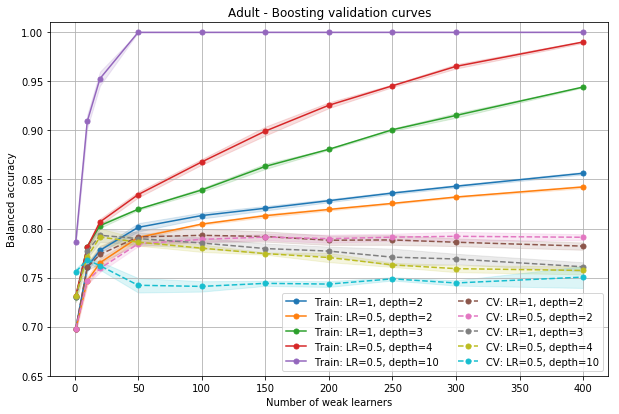

In [19]:
lr1= res_df.xs(1.0, level='learning_rate')
lr0_5 = res_df.xs(0.5, level='learning_rate')
lr0_75 = res_df.xs(0.5, level='learning_rate')

xs = lr1

mean_train, std_train, mean_test, std_test, mean_fit, std_fit, mean_score, std_score = {},{},{},{},{},{},{},{}

for d in param_grid['base_estimator__max_depth']:
    mean_train[d] = xs.xs(d, level='base_estimator__max_depth')['mean_train_score']
    std_train[d] = xs.xs(d, level='base_estimator__max_depth')['std_train_score']
    mean_test[d] = xs.xs(d, level='base_estimator__max_depth')['mean_test_score']
    std_test[d] = xs.xs(d, level='base_estimator__max_depth')['std_test_score']
    mean_fit[d] = xs.xs(d, level='base_estimator__max_depth')['mean_fit_time']
    std_fit[d] = xs.xs(d, level='base_estimator__max_depth')['std_fit_time']
    mean_score[d] = xs.xs(d, level='base_estimator__max_depth')['mean_score_time']
    std_score[d] = xs.xs(d, level='base_estimator__max_depth')['std_score_time']

means = [
    lr1.xs(2, level='base_estimator__max_depth')['mean_train_score'],
    lr0_5.xs(2, level='base_estimator__max_depth')['mean_train_score'],
    lr1.xs(3, level='base_estimator__max_depth')['mean_train_score'],
    lr0_5.xs(4, level='base_estimator__max_depth')['mean_train_score'],
    lr0_5.xs(10, level='base_estimator__max_depth')['mean_train_score'],
    lr1.xs(2, level='base_estimator__max_depth')['mean_test_score'],
    lr0_5.xs(2, level='base_estimator__max_depth')['mean_test_score'],
    lr1.xs(3, level='base_estimator__max_depth')['mean_test_score'],
    lr0_5.xs(4, level='base_estimator__max_depth')['mean_test_score'],
    lr0_5.xs(10, level='base_estimator__max_depth')['mean_test_score'],
]

stds = [
    lr1.xs(2, level='base_estimator__max_depth')['std_train_score'],
    lr0_5.xs(2, level='base_estimator__max_depth')['std_train_score'],
    lr1.xs(3, level='base_estimator__max_depth')['std_train_score'],
    lr0_5.xs(4, level='base_estimator__max_depth')['std_train_score'],
    lr0_5.xs(10, level='base_estimator__max_depth')['std_train_score'],
    lr1.xs(2, level='base_estimator__max_depth')['std_test_score'],
    lr0_5.xs(2, level='base_estimator__max_depth')['std_test_score'],
    lr1.xs(3, level='base_estimator__max_depth')['std_test_score'],    
    lr0_5.xs(4, level='base_estimator__max_depth')['std_test_score'],
    lr0_5.xs(10, level='base_estimator__max_depth')['std_test_score'],
]

series_labels = [
    'Train: LR=1, depth=2',
    'Train: LR=0.5, depth=2',
    'Train: LR=1, depth=3',
    'Train: LR=0.5, depth=4',
    'Train: LR=0.5, depth=10',
    'CV: LR=1, depth=2',
    'CV: LR=0.5, depth=2',
    'CV: LR=1, depth=3',
    'CV: LR=0.5, depth=4',
    'CV: LR=0.5, depth=10',
]

plot_means_w_stds(
    means,
    stds,
    param_grid['n_estimators'],
    series_labels=series_labels,
    legend=True,
    legend_kwargs={'ncol': 2},
    fig_kwargs={'figsize': (10,6.5)},
    ylim=[0.65, 1.01],
    xlabel='Number of weak learners',
    ylabel='Balanced accuracy',
    title='Adult - Boosting validation curves'
)

### Timing Analysis

In [39]:
res_df.sort_values(by='mean_fit_time').tail(10)

,,,mean_fit_time,std_fit_time,mean_score_time,std_score_time,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
base_estimator__max_depth,learning_rate,n_estimators,,,,,,,,,
8,0.75,400,96.369336,10.032005,0.787728,0.061419,0.750256,0.004829,208,0.999958,0.000052
9,0.50,400,97.379869,21.156170,0.882672,0.082674,0.748311,0.003746,225,0.999979,0.000021
6,1.00,400,98.454243,0.808720,0.709344,0.082056,0.750722,0.005171,200,0.999937,0.000063
10,0.50,400,99.745825,9.241567,0.840617,0.058243,0.750561,0.011057,204,0.999979,0.000021
6,0.50,400,101.745696,0.390293,0.758994,0.115467,0.753615,0.004349,160,0.999958,0.000052
8,0.50,400,103.634378,12.454831,0.831399,0.085825,0.753128,0.005801,164,0.999958,0.000052
6,0.75,400,104.661283,0.552392,0.820457,0.190588,0.750362,0.007830,206,0.999958,0.000052
8,1.00,400,105.228008,2.815884,0.788445,0.059989,0.750616,0.006603,202,0.999937,0.000063
7,0.50,400,109.733307,2.517517,0.757798,0.072043,0.754471,0.003455,154,0.999958,0.000052


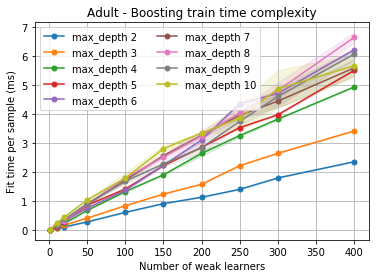

In [35]:
means = [mean_fit[d] for d in param_grid['base_estimator__max_depth']]
stds = [std_fit[d] for d in param_grid['base_estimator__max_depth']]
labels = ['max_depth %i' % i for i in param_grid['base_estimator__max_depth']]

# Calculate per-sample mean
n_samples = X_train_scaled.shape[0] * 3/4 # three-quarters of dataset was fit for 4-fold validation
# convert to milliseconds
means_per_samp = [mean_fit[d] / n_samples * 1000 for d in param_grid['base_estimator__max_depth']]
stds_per_samp = [std_fit[d] / n_samples * 1000  for d in param_grid['base_estimator__max_depth']]

plot_means_w_stds(
    means_per_samp,
    stds_per_samp,
    param_grid['n_estimators'],
    series_labels=labels,
    title='Adult - Boosting train time complexity',
    legend_kwargs={'loc': 'best', 'ncol': 2},
    ylabel='Fit time per sample (ms)',
    xlabel='Number of weak learners',
#     fig_kwargs={'figsize': (10,6)},
)

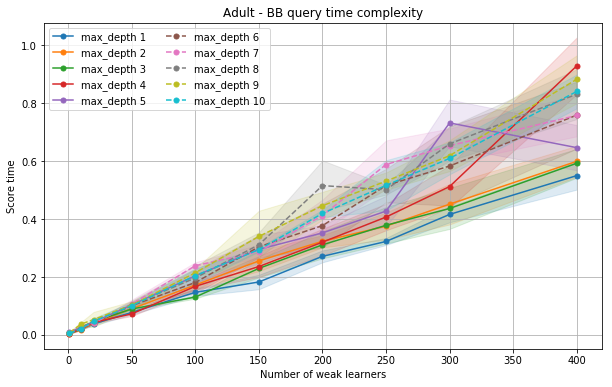

In [79]:
means = [mean_score[d] for d in param_grid['base_estimator__max_depth']]
stds = [std_score[d] for d in param_grid['base_estimator__max_depth']]

plot_means_w_stds(
    means,
    stds,
    param_grid['n_estimators'],
    series_labels=['max_depth %i' % i for i in param_grid['base_estimator__max_depth']],
    title='Adult - BB query time complexity',
    legend_kwargs={'loc': 'best', 'ncol': 2},
    ylabel='Score time',
    xlabel='Number of weak learners',
    fig_kwargs={'figsize': (10,6)},
)

## Boosting Learning Curve Analysis

In [45]:
# Find best estimator
clf = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=3),
    learning_rate=1.0,
    n_estimators=20
)
clf.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator__class_weight': None,
 'base_estimator__criterion': 'gini',
 'base_estimator__max_depth': 3,
 'base_estimator__max_features': None,
 'base_estimator__max_leaf_nodes': None,
 'base_estimator__min_impurity_decrease': 0.0,
 'base_estimator__min_impurity_split': None,
 'base_estimator__min_samples_leaf': 1,
 'base_estimator__min_samples_split': 2,
 'base_estimator__min_weight_fraction_leaf': 0.0,
 'base_estimator__presort': False,
 'base_estimator__random_state': None,
 'base_estimator__splitter': 'best',
 'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=None,
             splitter='best'),
 'learning_rate': 1.0,
 'n_estimators': 20,
 'random_state': None}

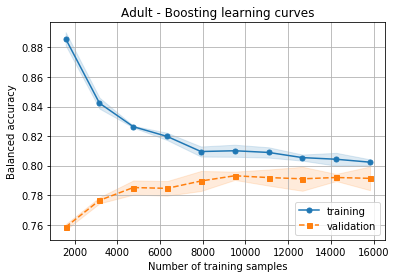

In [46]:
train_sizes, train_mean, train_std, test_mean, test_std = gen_and_plot_learning_curve(clf, X_train_scaled, y_train, ylim=None, cv=4, n_jobs=-1, scoring=balanced_accuracy_scorer, ylabel='Balanced accuracy', title='Adult - Boosting learning curves')

# Performance on Test Set

In [34]:
best_clf = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=3),
    learning_rate=1.0,
    n_estimators=20,
    random_state=1
)

best_clf.fit(X_train_scaled, y_train)
y_test_pred = best_clf.predict(X_test_scaled)
test_score = balanced_accuracy(y_test, y_test_pred)
print('%.4f' % test_score)

0.7968
